# Lecture 4 In-Class Assignment: Sensory Feedback in a 1D Movement Task

This assignment extends our 1D arm model to incorporate two sensory systems:
- **Proprioception** (short delay, small noise)
- **Touch** (contact force at a wall)

We will test three conditions:
1. **No Sensation** (feedforward only)
2. **Proprioception** only
3. **Proprio + Touch**

**Goal**: Move from x=0.0 to x=1.0 (a "wall") and apply a contact force within [2.0, 4.0] N.

## Outline
1. [Imports & Setup](#section1)
2. [1D Plant](#section2)
3. [Sensory Systems](#section3)
4. [Condition 1: No Sensation](#section4)
5. [Condition 2: Proprioception Only](#section5)
6. [Condition 3: Proprio + Touch](#section6)
7. [Discussion / Bonus](#section7)

**Instructions**:
- Each part has a Markdown explanation followed by code cells.
- Controller functions have placeholder code returning (0.0, 0.0).
- Cells labeled "STUDENT CODE HERE" are where you implement your logic.
- You can re-run simulations after each change to see how performance improves.

<a id="section1"></a>
## 1) Imports & Setup
**DO NOT EDIT**: Basic setup, constants, and time array.

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import collections

np.random.seed(42)  # For reproducible randomness

# Simulation parameters
dt = 0.001
t_final = 2.0
time = np.arange(0, t_final, dt)

# Task parameters
TARGET_POS = 1.0              # "Wall" position
FORCE_WINDOW = (2.0, 4.0)     # Desired contact force range (N)

# Helper function to plot results
def plot_results(t_array, x_array, force_array, label):
    fig, ax = plt.subplots(2, 1, figsize=(6,4))
    ax[0].plot(t_array, x_array, label='Position')
    ax[0].axhline(TARGET_POS, color='r', linestyle='--', label='Wall Pos')
    ax[0].set_ylim(0, 1.5)
    ax[0].set_title(label)
    ax[0].legend()

    ax[1].plot(t_array, force_array, label='Contact Force')
    ax[1].axhline(FORCE_WINDOW[0], color='g', linestyle='--', label='Force Min')
    ax[1].axhline(FORCE_WINDOW[1], color='g', linestyle='--', label='Force Max')
    ax[1].legend()
    ax[1].set_ylim(0, 5)

<a id="section2"></a>
## 2) 1D Plant

A simple model with flexor vs. extensor forces on a mass, plus friction.

**DO NOT EDIT**: We keep this consistent for everyone.



In [201]:
class OneDMusclePlant:
    """
    1D arm with minimal muscle dynamics: flexor vs. extensor forces on a mass.
    """
    def __init__(self, mass=1.0):
        self.mass = mass
        self.x = 0.0  # position
        self.v = 0.0  # velocity

    def update(self, flexor_force, extensor_force, dt):
        """
        Update the arm state given muscle forces + friction.
        """
        net_force = flexor_force - extensor_force
        friction = 0.1 * self.v
        net_force -= friction

        a = net_force / self.mass
        self.v += a * dt
        self.x += self.v * dt

        return self.x, self.v

<a id="section3"></a>
## 3) Sensory Systems

We simulate delays and noise for:
- **Proprioception**: ~20 ms delay, small noise
- **Touch**: Only reads nonzero if x >= TARGET_POS, plus small noise

**DO NOT EDIT** unless you want to experiment after finishing the assignment.



In [202]:
class DelayedSignal:
    """
    Utility for simulating delayed signals with a FIFO buffer.
    """
    def __init__(self, delay_steps):
        self.delay_steps = delay_steps
        self.buffer = collections.deque([0.0]*delay_steps, maxlen=delay_steps)

    def __call__(self, current_value):
        oldest_val = self.buffer[0]
        self.buffer.append(current_value)
        return oldest_val

# Delays
proprio_delay = DelayedSignal(delay_steps=20)   # ~20 ms
proprio_vel_delay = DelayedSignal(delay_steps=20)

# Noise levels
proprio_noise_std = 0.03         # in m (3cm)
proprio_noise_vel_std = 0.02     # fraction of velocity
touch_noise_std   = 0.1          # fraction of touch force

def get_proprioceptive_feedback(actual_pos, actual_vel):
    # Delay
    delayed_pos = proprio_delay(actual_pos)
    delayed_vel = proprio_vel_delay(actual_vel)
    # Add noise
    pos_with_noise = delayed_pos + np.random.normal(0, proprio_noise_std)
    vel_with_noise = delayed_vel + np.random.normal(0, abs(proprio_noise_vel_std * actual_vel))
    return pos_with_noise, vel_with_noise

def get_touch_feedback(actual_pos, contact_force):
    # If x < TARGET_POS => no contact
    if actual_pos < TARGET_POS:
        return 0.0
    else:
        return contact_force + np.random.normal(0, touch_noise_std * contact_force)

### Contact Force Model
For the wall, we define a spring-damper if x > 1.0, else 0.0. We'll handle that in the simulation.

### Simulation Function
We'll create a helper function to run the simulation for a given controller.



In [203]:
def run_simulation(controller_func, label):
    """
    Runs the simulation with the given controller.
    Returns logs for position (x_array) and contact force (force_array).
    """
    plant = OneDMusclePlant()
    
    x_log = []
    force_log = []
    
    # Wall parameters
    wall_stiffness = 360.0  # Stiffness (N/m)
    wall_damping = 1.2     # Damping (N*s/m)

    for i, t in enumerate(time):
        overlap = plant.x - TARGET_POS
        if overlap > 0:
            # Contact force from a stiff, damped wall
            contact_force = wall_stiffness * overlap + wall_damping * plant.v
            # If the damping term is negative (pulling the arm forward), clamp to 0
            if contact_force < 0:
                contact_force = 0.0
        else:
            contact_force = 0.0

        # Controller decides muscle forces
        flex, exten = controller_func(i, t, plant.x, plant.v, contact_force)

        # Clamp negative muscle commands to 0
        if flex < 0:
            flex = 0.0
        if exten < 0:
            exten = 0.0

        # If the arm is beyond the wall, add the wall’s push-back as extensor force
        if plant.x > TARGET_POS:
            exten += contact_force

        plant.update(flex, exten, dt)

        x_log.append(plant.x)
        force_log.append(contact_force)
    
    return np.array(x_log), np.array(force_log)

<a id="section4"></a>
## 4) Condition 1: No Sensation

We have **no feedback** about position or force. It's purely feedforward.

**Student Task**: Implement a simple time-based force in the placeholder below.

In [204]:
def controller_no_sensation(time_idx, t, plant_x, plant_v, contact_force):
    """
    STUDENT CODE HERE:
    Open-loop controller: using only time to decide when to push.
    """
    if t < 0.29:
        flexor = 13.0
        extensor = 0.0
    elif t < 0.5:
        flexor = 0.0
        extensor = 16.5
    else:
        flexor = 0.07
        extensor = 0.0
    return (flexor, extensor)

### Simulation & Plot: No Sensation

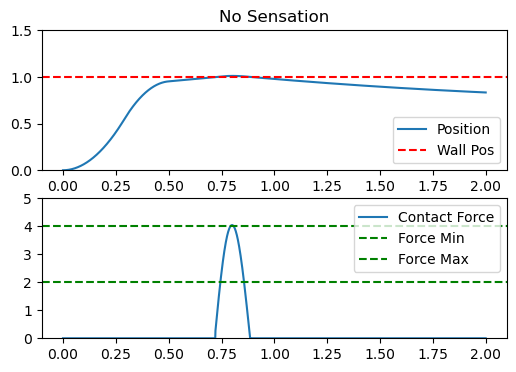

In [205]:
x_noSens, f_noSens = run_simulation(controller_no_sensation, label="No Sensation")
plot_results(time, x_noSens, f_noSens, label="No Sensation")
plt.show()

**Questions**:
- Can you reach the wall or at least get near it?
- How might you guess how long/strong to push so you end up with force in [2.0, 4.0]?

<a id="section5"></a>
## 5) Condition 2: Proprioception Only

We can use `prop_x, prop_v = get_proprioceptive_feedback(plant_x, plant_v)`.
- There's a ~20 ms delay, small noise.

**Student Task**: Implement a simple P or PD controller to reach ~x=1.0.

In [210]:
def controller_proprio(time_idx, t, plant_x, plant_v, contact_force):
    """
    PD controller with a near-contact mode using proprioceptive feedback.
    
    - Far from the wall (prop_x < TARGET_POS - margin): use a PD controller.
    - Near the wall (within a small margin): switch to a steady flexor force
      to generate the desired contact force.
      
    Tweak the margin and constant force as needed for best performance.
    """
    # Get the delayed, noisy feedback
    prop_x, prop_v = get_proprioceptive_feedback(plant_x, plant_v)
    
    margin = 0.03
    if prop_x < TARGET_POS - margin:
        # Use PD control when far from contact:
        error = TARGET_POS - prop_x
        kp = 450.0
        kd = 50.0
        control_force = kp * error - kd * prop_v
    else:
        # Once near the wall, apply a small constant flexor force.
        control_force = 0.03  # Adjust as needed for correct contact force
    
    # Apply force in one channel depending on the sign.
    if control_force >= 0:
        flexor = control_force
        extensor = 0.0
    else:
        flexor = 0.0
        extensor = -control_force
    
    return (flexor, extensor)

### Simulation & Plot: Proprioception

<Figure size 600x400 with 0 Axes>

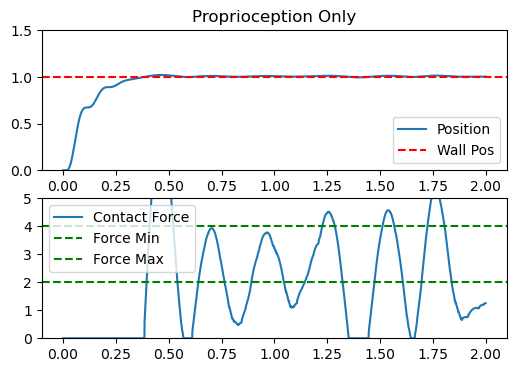

In [211]:
x_prop, f_prop = run_simulation(controller_proprio, label="Proprio Only")
plt.figure(figsize=(6,4))
plot_results(time, x_prop, f_prop, label="Proprioception Only")
plt.show()

**Questions**:
- Are you able to stop at the wall?
- Without direct force feedback, can you ensure the correct contact force?

<a id="section6"></a>
## 6) Condition 3: Proprio + Touch

Now you have 
```python
  prop_x, prop_v = get_proprioceptive_feedback(plant_x, plant_v)
  touch_f = get_touch_feedback(plant_x, contact_force)
```
as your sensed position/velocity and contact force.

**Goal**: Approach the wall and maintain a contact force in [2.0, 4.0].

In [212]:
def controller_touch(time_idx, t, plant_x, plant_v, contact_force):
    """
    PD controller with touch feedback. When far from the wall, it uses a standard PD law
    based on proprioceptive feedback. Once near the wall, it uses touch feedback to adjust
    the force in order to achieve a target contact force.
    """
    # Get noisy, delayed proprioceptive feedback
    prop_x, prop_v = get_proprioceptive_feedback(plant_x, plant_v)
    
    # Get touch feedback (zero if not in contact)
    touch_f = get_touch_feedback(plant_x, contact_force)
    
    margin = 0.001
    if prop_x < TARGET_POS - margin:
        # Far from the wall: PD law on position
        error = TARGET_POS - prop_x
        kp = 400.0
        kd = 50.0
        control_force = kp * error - kd * prop_v
    else:
        # Near the wall: Use touch feedback to achieve ~3N
        desired_touch = 3.0
        error_touch = desired_touch - touch_f
        kp_touch = 3.0
        control_force = kp_touch * error_touch

    if control_force >= 0:
        flexor = control_force
        extensor = 0.0
    else:
        flexor = 0.0
        extensor = -control_force
        
    return (flexor, extensor)

### Simulation & Plot: Proprio + Touch

<Figure size 600x400 with 0 Axes>

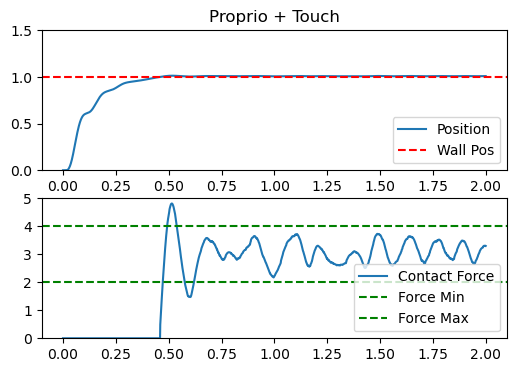

In [ ]:
x_touch, f_touch = run_simulation(controller_touch, label="Proprio + Touch")
plt.figure(figsize=(6,4))
plot_results(time, x_touch, f_touch, label="Proprio + Touch")
plt.show()

**Check**:
- Do you ever see stable contact force in [2,4] N?
- If not, how can you tweak your control logic?

<a id="section7"></a>
## 7) Discussion / Bonus

1. **Compare** the final position and contact force in each condition.
2. **Tune** your control laws until you see consistent force in [2,4] N at the end.
3. (Bonus) Plot error vs. time or measure how quickly each condition stabilizes. 
4. (Bonus) Consider adding a simple gain schedule: push hard at first, then reduce gains near x=1.

Submit your final code when you’re done!